# Ejercicio EvCont4 (c) - Compresión LZZ7-AUDIO

* Óscar Sementé Solà
* Abdelkarim Azzouguagh Ouniri
* Rodrigo Cabezas Quirós

In [13]:
import math, re

class LZZ7Compressor:
    
    def __init__(self, win, wsld):
        self.win = win
        self.wsld = wsld
        self.win_b = int(math.log2(win))
        self.wsld_b = int(math.log2(wsld))
    
    def __is_power_of_two(self, v):
        return math.log2(v).is_integer()
    
    def __ld_to_bin(self, l, d, useLD):
        """
        Transforma (L, D) a formato binario de longitud fija.
        """
        b_win = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(self.win_b)]))
        b_wsld = lambda x : ''.join(reversed( [str((x >> i) & 1) for i in range(self.wsld_b)]))
        if useLD:
            return (l, d)
        return b_win(l) + b_wsld(d)
    
    def __match_pattern(self, slide, inp, useLD):
        """
        Busca un patrón de la ventana de entrada en la ventana deslizante. Si lo encuentra devuelve
        (L, D) en decimal o en formato binario (según valor de 'useLD') y la longitud del patrón
        encontrado. Si no lo encuentra devuelve False y 1 (incremento del offset).
        """
        occ, seqs = [], [inp[:i] for i in range(len(inp), 0, -1)]
        while seqs:
            current = seqs.pop(0)
            occ = [(x.start(0), x.end(0)) for x in re.finditer(current, slide)]
            if occ:
                si, ei = occ[-1]
                return self.__ld_to_bin(len(slide[si:ei]), len(slide) - si, useLD), ei - si
        return False, 1
    
    def compress(self, m, useLD=False):
        """
        Compresión de una string binaria a partir de la configuración del compresor.
        """
        if not self.win <= self.wsld and not len(m) >= self.win + self.wsld:
            """
            Que los bits de conf. sean potencia de 2 no tiene ningún sentido. El ejercicio evaluado en
            clase tenía por parametros 8 y 6 bits. Aplicando la norma de la potencia de 2, con 6 bits no
            funcionaria el algoritmo. Así que hemos aplicado esta política.
            or \ not self.__is_power_of_two(self.win) \ or not self.__is_power_of_two(self.wsld):
            """
            return -1
        # Se aplica método de inserción de bit, para los casos problematicos.
        offset, m = 0, self.__add_insertion_bits(m)
        ret = [m[:self.wsld]]
        while offset + self.wsld + self.win <= len(m):
            # Búsqueda de patrón de la ventana de entrada en la deslizante.
            slide = m[offset:offset + self.wsld]
            inp = m[offset + self.wsld:offset + self.wsld + self.win]
            found, flen = self.__match_pattern(slide, inp, useLD)
            if found:
                # Si se encuentra se añade al retorno.
                ret.append(found)
            else:
                # Si no se guarda el símbolo (en formato (L, D) tal y como especifica el enunciado).
                ret.append(self.__ld_to_bin(1, 1, useLD))
            offset -= -flen
        # Si al acabar quedan bits fuera de las ventanas, se añaden al final de la cadena.
        if offset < len(m):
            ret.append(m[offset + self.wsld:])
        if useLD:
            return ret
        return "".join(ret)
    
    def uncompress(self, m):
        """
        Descompresión de una string binaria a partir de la configuración del compresor.
        """
        ret = m[:self.wsld]
        div = [m[i:i+self.wsld_b+self.win_b] for i in range(self.wsld, len(m), self.wsld_b + self.win_b)]
        lf = lambda x: 2**self.win_b if x == 0 else x
        df = lambda x: 2**self.wsld_b if x == 0 else x
        while div:
            c = div.pop(0)
            if len(c) < self.wsld_b + self.win_b:
                ret = ret + c
            else:
                l, d = lf(int(c[:self.win_b], 2)), df(int(c[self.win_b:], 2))
                ret = ret + ret[len(ret) - d: len(ret) + l - d]
        return self.__remove_insertion_bits(ret)
    
    def __add_insertion_bits(self, m):
        """
        Aplica método de inserción de bit para las entradas con un solo carácter.
        """
        asd = [m[i:i + self.wsld - 1] for i in range(0, len(m), self.wsld - 1)]
        opposite = lambda x: "0" if x == "1" else "1"
        for i in range(len(asd)):
            if asd[i] == asd[i][0] * len(asd[i]) and len(asd[i]) == self.wsld - 1:
                asd[i] = asd[i] + opposite(asd[i][0])
        return "".join(asd)
    
    def __remove_insertion_bits(self, m):
        """
        Desaplica método de inserción de bit para las entradas con un solo carácter.
        """
        opposite = lambda x: "0" if x == "1" else "1"
        for i in range(0, len(m), self.wsld):
            p = m[i:i + self.wsld]
            if p[:-1] == p[0] * len(p[:-1]) and p[-1] == opposite(p[0]):
                m = m[:i + self.wsld-1] + m[i+self.wsld:]
        return m

#### [Apartado 1] Haced las modificaciones necesarias en el programa anterior para que sea capaz de leer ficheros de audio en formato .wav, obtener el código binario natural de cada unos de los enteros (int) de los que se compone el sonido (16bits por dato) y devolverlo como una String binaria procesable por vuestros métodos de compresión /descompresión en LZ-77.

In [14]:
import wave
def readWavFile(file_name):
    w = wave.open(file_name, "rb")
    binary_data = w.readframes(w.getnframes())
    txt = ''
    for i in binary_data:
        txt += bin(i)[2:].zfill(16)
    w.close()
    return txt

readWavFile("data.wav")

'000000001100010100000000000000010000000010110010000000000000000100000000100110100000000000000001000000001000001100000000000000010000000001100110000000000000000100000000010010000000000000000001000000000010011000000000000000010000000000001000000000000000000100000000111011010000000000000000000000001101101000000000000000000000000011001001000000000000000000000000101111000000000000000000000000001011000000000000000000000000000010101001000000000000000000000000101010000000000000000000000000001010100100000000000000000000000010101000000000000000000000000000101000100000000000000000000000001001010100000000000000000000000010000100000000000000000000000000011101010000000000000000000000000110100000000000000000000000000001100010000000000000000000000000011000010000000000000000000000000110011000000000000000000000000001100111000000000000000000000000011001100000000000000000000000000110000000000000000000000000000001011101000000000000000000000000010110010000000000000000000000000101011000000000000000000000000

#### [Apartado 2] En el Ej. AvCont-5, implementasteis métodos para hallar el código Rice de un número entero, dado un parámetro de compresión M. Modificad el programa anterior para que, codifique los datos enteros (int) de audio en codificación Rice antes de realizar la compresión LZ-77. Emplead el parámetro de compresión M que juzguéis más adecuado según lo discutido en clase (es decir, con el que se logra más compresión).

In [15]:
from math import ceil, log2

def rice_codification(M, file_name):
    w = wave.open(file_name, "rb")
    binary_data = w.readframes(w.getnframes())
    txt = ''
    for i in binary_data:
        ret, signo, Q, R =  "", "", "", ""
        # Comprobamos signo
        signo = "0" if i < 0 else "1"
        # Calculamos el cociente
        Q = "1" * int(abs(i)/M) + "0"
        # Calculamos el residuo
        R = "{0:b}".format(abs(i)%M).zfill(ceil(log2(M)))
        txt += signo + Q + R
    w.close()
    return txt

In [16]:
length = 99999999999
text = ''
M = 0
for i in range(1,256):
    a =  rice_codification(i, "data.wav")
    if len(a) < length:
        length = len(a)
        text = a
        M = i
print("M= {}, msg = {}".format(M, text))

M= 64, msg = 111100001011000000111101100101000000111100110101000000111100000111000000111010011010000001110001000100000011010011010000001100010001000000111110101101100000001111001101010000000111100010011000000011101111001000000011101100001000000011101010011000000011101010001000000011101010011000000011101010001000000011101000101000000011100101011000000011100001001000000011011010110000000110101000100000001101000101000000011010000110000000110100110100000001101001111000000011010011010000000110100000100000001100111011000000011001100110000000110010110100000001100010011000000010111010100000001010100010000000100111001000000010010001100000001001000010000000100100001000000010011000100000001010000010000000101010001000000010101101100000001011001010000000101101011000000010111100100000001100001101000000011001000010000000110011011100000001101010001000000011011110010000000111001010010000000111010100110000000111011010110000000111011110010000000111011111110000000111100001101000000011110001111100000001111

COMENTARIO: Tras realizar varios tests con valores de M comprendidos en el rango [1, 256], hemos podido observar que con M=64 nos da una mayor copresión de los datos.

#### [Apartado 3] Utilizando los programas anteriores comprimid en “LZ-77” i en “Rice+LZ-77” el archivo “data.wav” que se os proporciona (sonido en formato wav monocanal). Fijando distintos valores de Mdes y Ment entre 4 y 4096 y analizad el factor de compresión en cada caso. ¿Qué conclusiones sacáis?

In [17]:
'''
Compresión en LZ77
'''   
vals = [(6,8),(12, 32), (4, 16), (10, 16), (32, 56)]
msg = readWavFile("data.wav")
for i, j in vals:
    comp = LZZ7Compressor(i, j)
    print("Length for vals [{}, {}] is {}".format(i, j, len(comp.compress(msg))))

Length for vals [6, 8] is 128942
Length for vals [12, 32] is 63988
Length for vals [4, 16] is 122401
Length for vals [10, 16] is 94339
Length for vals [32, 56] is 52590


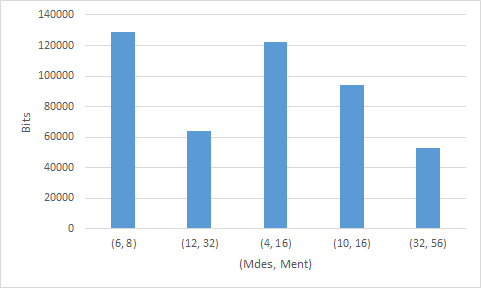

COMENTARIO: Tras realizar pruebas con los valores que se pueden ver en la gráfica, hemos podido observar que usando una ventana de entrada de 56 bits y una deslizante de 32 bits se obtiene una mayor compresión en cuanto a cantidad de bits.

In [18]:
'''
Compresión en Rice-LZ77
'''    
vals = [(6,8),(12, 32), (4, 16), (10, 16), (32, 56)]
msg = rice_codification(64,"data.wav")
for i, j in vals:
    comp = LZZ7Compressor(i, j)
    print("Length for vals [{}, {}] is {}".format(i, j, len(comp.compress(msg))))

Length for vals [6, 8] is 75142
Length for vals [12, 32] is 45988
Length for vals [4, 16] is 69730
Length for vals [10, 16] is 67182
Length for vals [32, 56] is 46634


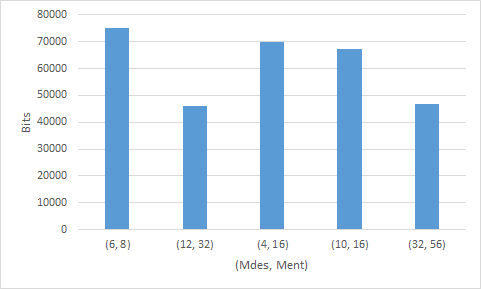

COMENTARIO: Usando M=64, valor optimo sacado del apartado anterior, y tras realizar pruebas con los valores que se pueden ver en la gráfica, hemos podido observar que usando una ventana de entrada de 32 bits y una deslizante de 12 bits o 32 y 56 respectivamente, se obtiene una mayor compresión, relativamente igual para ambos valores,en cuanto a cantidad de bits.